In [1]:
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow
from joblib import Parallel, delayed

import os
import shutil
import platform

import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

mpl.rc('font', size=14)

2024-10-15 22:06:25.812201: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 22:06:25.812224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 22:06:25.862569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 22:06:25.965690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 22:06:31.417323: W tensorflow/compiler/tf2

In [2]:
def network(input_shape, ncat, learning_rate=0.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [3]:
x = np.load("x.npy")
y = np.load("y.npy")
labels = np.load("labels.npy")
ntypes = len(labels)
ngalaxy, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nkn, ntde, nbins = np.load("ns.npy")

In [4]:
model = network((nbins, 1), ncat=y.shape[1])
model.summary()

2024-10-08 09:50:17.256869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38384 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Model: "SNnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Spec (InputLayer)     [(None, 160, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 160, 8)            48        
                                                                 
 batch_normalization (Batch  (None, 160, 8)            32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 160, 8)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 80, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 16)            656   

In [5]:
n_sample = [ngalaxy, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nkn, ntde]
weights = np.max(n_sample) / n_sample
class_weight = {}
for i in range(len(weights)):
    class_weight[i] = weights[i]
class_weight

{0: 1.0002006219279767,
 1: 1.0007025291047773,
 2: 1.0013054830287207,
 3: 1.0,
 4: 1.2058289998790663,
 5: 1.0022112775153282,
 6: 1.002312022517089,
 7: 1.0009034330455733,
 8: 1.1144517715435343,
 9: 178.05357142857142}

In [6]:
x.shape, y.shape

((86993, 160, 1), (86993, 10))

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 2)

In [8]:
print(np.sum(y_test[:,9]))
print(np.sum(y_train[:,9]))

10.0
46.0


In [9]:
batch = 30
epoch = 150

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=40)
mc = ModelCheckpoint('b{}_e{}_best_model_l_cut.keras'.format(batch, epoch), monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(x_train, y_train, batch_size=batch, epochs=epoch, validation_data=(x_test, y_test), shuffle=True, verbose=True, callbacks=[es, mc], class_weight=class_weight)

Epoch 1/150


2024-10-08 09:50:42.838582: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2024-10-08 09:50:44.186487: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4a69f22f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-08 09:50:44.186503: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-10-08 09:50:44.192213: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1728406244.287023  213314 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2320/2320 [==============================] - ETA: 0s - loss: 3.7928 - accuracy: 0.4300
Epoch 1: val_loss improved from inf to 2.83233, saving model to b30_e150_best_model_l_cut.h5
2320/2320 [==============================] - 19s 6ms/step - loss: 3.7928 - accuracy: 0.4300 - val_loss: 2.8323 - val_accuracy: 0.4911
Epoch 2/150
  12/2320 [..............................] - ETA: 11s - loss: 2.8852 - accuracy: 0.4722

/global/common/software/nersc9/tensorflow/2.15.0/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2311/2320 [============================>.] - ETA: 0s - loss: 2.7747 - accuracy: 0.4830
Epoch 2: val_loss improved from 2.83233 to 2.66142, saving model to b30_e150_best_model_l_cut.h5
2320/2320 [==============================] - 12s 5ms/step - loss: 2.7740 - accuracy: 0.4831 - val_loss: 2.6614 - val_accuracy: 0.4731
Epoch 3/150
2316/2320 [============================>.] - ETA: 0s - loss: 2.7018 - accuracy: 0.4909
Epoch 3: val_loss improved from 2.66142 to 2.65229, saving model to b30_e150_best_model_l_cut.h5
2320/2320 [==============================] - 12s 5ms/step - loss: 2.7018 - accuracy: 0.4909 - val_loss: 2.6523 - val_accuracy: 0.4951
Epoch 4/150
2310/2320 [============================>.] - ETA: 0s - loss: 2.5059 - accuracy: 0.5027
Epoch 4: val_loss improved from 2.65229 to 2.46097, saving model to b30_e150_best_model_l_cut.h5
2320/2320 [==============================] - 12s 5ms/step - loss: 2.5061 - accuracy: 0.5028 - val_loss: 2.4610 - val_accuracy: 0.4977
Epoch 5/150
2320/2320 

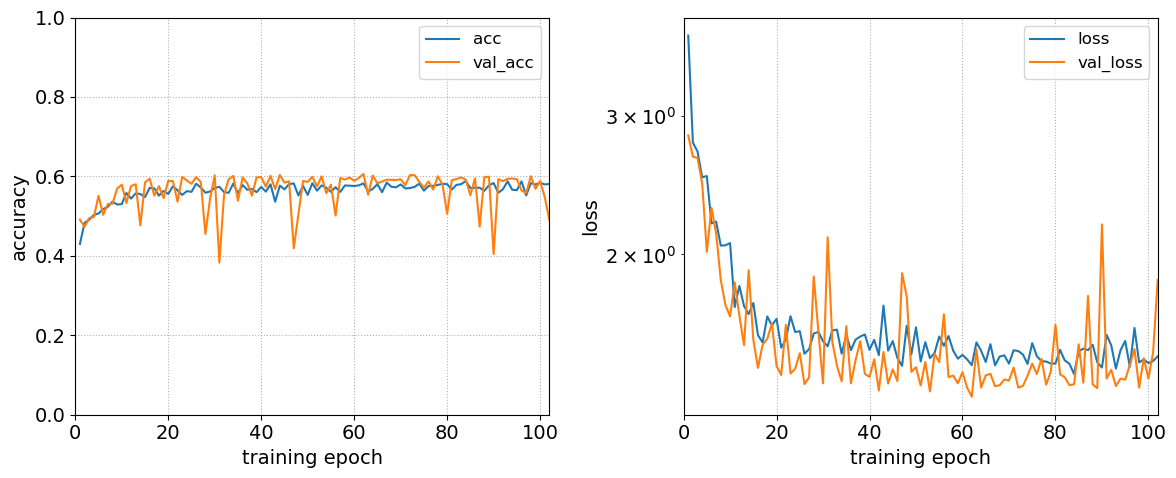

In [10]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')
ax.set_yscale("log")

fig.tight_layout()
plt.savefig('b{}_e{}_accuracy.png'.format(batch, epoch))

In [11]:
tde_test = np.load("tde_flux_2.npy").reshape(-1, nbins, 1)
tde_test.shape

(27, 160, 1)

In [12]:
x_test.shape

(17399, 160, 1)

1/1 [==============================] - 0s 226ms/step


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 26.]),
 array([0.99969983, 0.99972987, 0.99975985, 0.99978989, 0.99981987,
        0.99984992, 0.99987996, 0.99990994, 0.99993998, 0.99996996,
        1.        ]),
 <BarContainer object of 10 artists>)

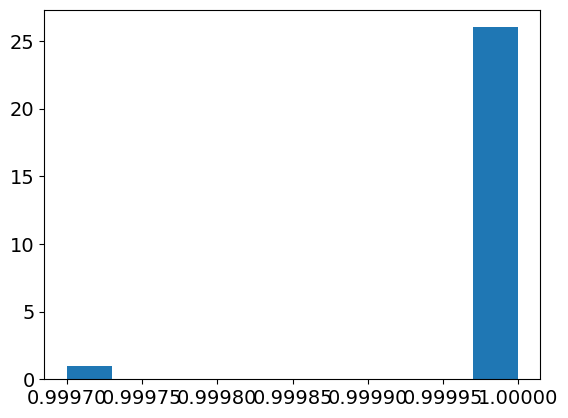

In [13]:
tde_pred = model.predict(tde_test)
plt.hist(tde_pred[:,9])

In [14]:
y_pred = model.predict(x_test)
y_pred

544/544 [==============================] - 1s 1ms/step


array([[8.2932720e-03, 2.9731045e-02, 1.4666459e-01, ..., 9.2664091e-03,
        1.4298671e-03, 2.3048723e-03],
       [7.4351485e-09, 1.6241544e-10, 1.2733062e-07, ..., 9.9999750e-01,
        1.3060153e-07, 1.0543593e-09],
       [8.9777395e-04, 7.2511210e-04, 1.0723450e-03, ..., 3.4876895e-01,
        1.1364853e-03, 1.2896708e-05],
       ...,
       [1.6488529e-07, 2.3407956e-06, 9.8890358e-01, ..., 8.4638532e-06,
        2.7647614e-03, 5.1217228e-08],
       [1.5695404e-07, 4.5207556e-04, 6.1516728e-02, ..., 1.9229330e-05,
        1.4215742e-05, 6.7676137e-07],
       [6.1829751e-03, 9.8759860e-02, 2.8631881e-01, ..., 1.6483421e-02,
        2.8280711e-02, 6.6574113e-03]], dtype=float32)

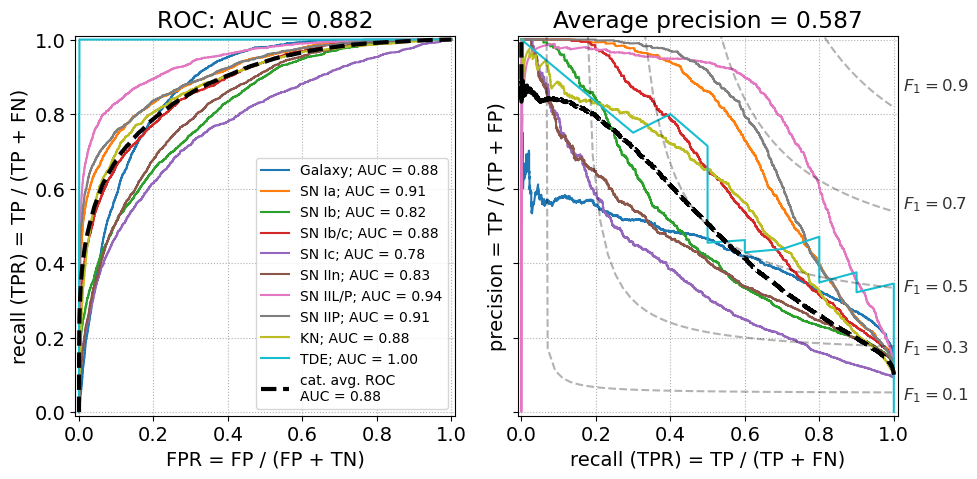

In [15]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()
plt.savefig('b{}_e{}_metrics.png'.format(batch, epoch))

In [16]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

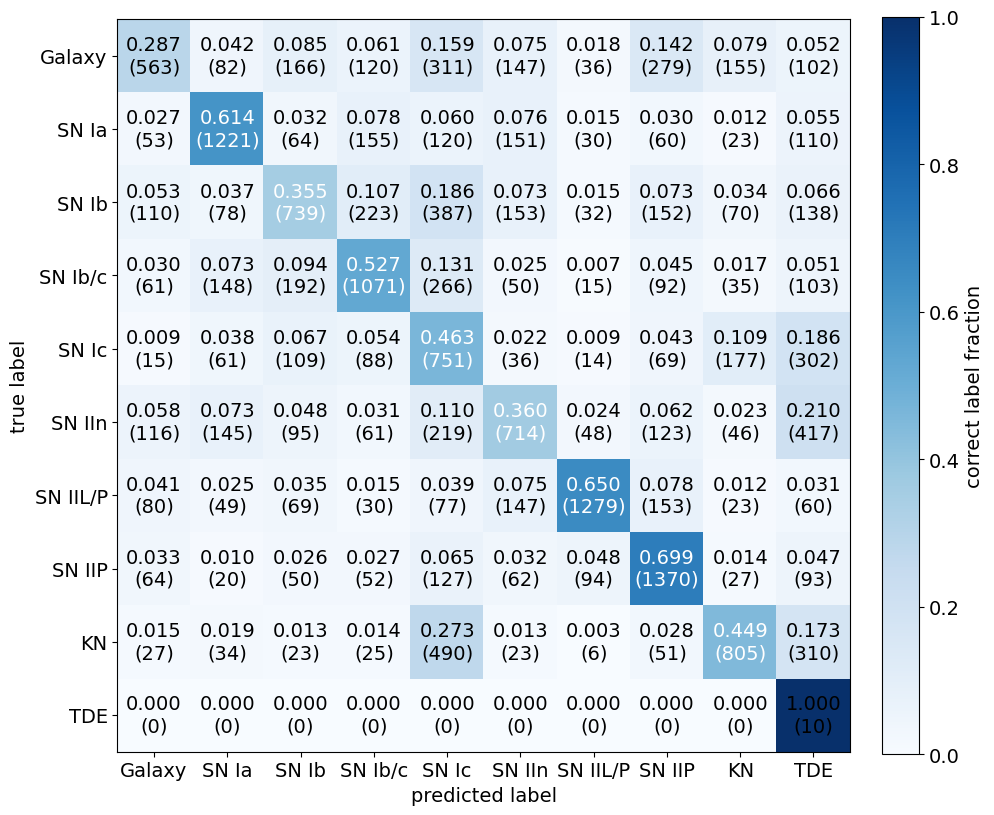

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

plt.tight_layout()
plt.savefig('b{}_e{}_matrix.png'.format(batch, epoch))